In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow
import pandas as pd

%matplotlib inline
from glob import glob

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

import time 

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

20% Fast Method

In [4]:
train_data_dir = "/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/unique_20_sample_train"
test_data_dir = "/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/unique_20_sample_test"

In [5]:
path = train_data_dir
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}
    

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}
imageid_path_dict


{}

In [6]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)

train_datagen = ImageDataGenerator(
      rescale = 1./255)

train_generator =train_datagen.flow_from_directory(
     train_data_dir,
     batch_size= 8,
     seed=42,
     shuffle=True, 
     target_size = (224,224))

test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator =test_datagen.flow_from_directory(
     test_data_dir,
     batch_size= 1,
     seed=42,
     shuffle=False, 
     target_size = (224,224)) 

Found 1205 images belonging to 3 classes.
Found 257 images belonging to 3 classes.


In [7]:
num_pneumonia = len(os.listdir(os.path.join(train_data_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_data_dir, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_data_dir, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
# class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [32]:
y_train = train_generator.classes
y_train
y_train_list = y_train.tolist()

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [10]:
class_weight = []
for i in y_train_list:
  if i == 0:
    class_weight.append(weight_for_0)
  elif i == 1:
    class_weight.append(weight_for_1)
  else:
    class_weight.append(weight_for_2)

In [11]:
class_weight_array = np.array(class_weight)

In [17]:
class_weight_array

array([0.22323651, 0.22323651, 0.22323651, ..., 0.56680498, 0.56680498,
       0.56680498])

In [13]:
SIZE = 224 

In [14]:
#############################
#Load model without classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [15]:
%time
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(train_generator)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


In [16]:
#xgboost takes image in shape of two. So need to reshape (320,8,8,512) 320 Images.
#8x8x512 = 32768
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
#features shape = (320,32768)
X_for_training = features #This is our X input to RF

In [18]:
#Send test data through same feature extractor process
#Need to extract features first from test data, then predict
X_test_feature = VGG_model.predict(test_generator) #extract features using feature extractor(VGG_model.predict)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [19]:
test_labels = test_generator.classes

In [76]:
%time
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier(
 learning_rate =0.1,
 objective= 'multi:softprob',
 n_estimators= 100,
 max_depth=4,
 min_child_weight=1,
 gamma=0.65,
 subsample=0.8,
 colsample_bytree=0.8,
 scale_pos_weight=0.8,
 seed=27)
eval_set = [(X_test_features, test_labels)]
model.fit(X_for_training, y_train, early_stopping_rounds=50, eval_metric="mlogloss", eval_set=eval_set, verbose=True)
# model.fit(X_for_training, y_train, early_stopping_rounds=50, eval_metric="mlogloss", eval_set=eval_set, verbose=True, sample_weight= class_weight_array)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs
[0]	validation_0-mlogloss:1.06342
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.04137
[2]	validation_0-mlogloss:1.02357
[3]	validation_0-mlogloss:1.00627
[4]	validation_0-mlogloss:0.987069
[5]	validation_0-mlogloss:0.977503
[6]	validation_0-mlogloss:0.962787
[7]	validation_0-mlogloss:0.956007
[8]	validation_0-mlogloss:0.947034
[9]	validation_0-mlogloss:0.937313
[10]	validation_0-mlogloss:0.925159
[11]	validation_0-mlogloss:0.924042
[12]	validation_0-mlogloss:0.920162
[13]	validation_0-mlogloss:0.915341
[14]	validation_0-mlogloss:0.91461
[15]	validation_0-mlogloss:0.906467
[16]	validation_0-mlogloss:0.904338
[17]	validation_0-mlogloss:0.898187
[18]	validation_0-mlogloss:0.897193
[19]	validation_0-mlogloss:0.894099
[20]	validation_0-mlogloss:0.890304
[21]	validation_0-mlogloss:0.889044
[22]	validation_0-mlogloss:0.888887
[23]	validation_0-mlogloss:0.885568
[24]	validation_0-ml

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.65,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import RandomizedSearchCV
from sklearn.metrics import XGBRegressor
from sklearn.metrics import fbeta_score, make_scorer

# param <- list("objective" = "multi:softprob",    # multiclass classification 
#               "num_class" = 12,    # number of classes 
#               "eval_metric" = "merror",    # evaluation metric 
#               "nthread" = 6,   # number of threads to be used 
#               "max_depth" = 15,    # maximum depth of tree 
#               "eta" = 0.07,    # step size shrinkage 
#               "subsample" = 0.8,    # part of data instances to grow tree 
#               "colsample_bytree" = 0.9  # subsample ratio of columns when constructing each tree 
              
# )

parameters = {'objective':['multi:softprob'],
              'num_class' = 3, 
              'eval_metric' = "merror",   
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1], 
              'max_depth': [5,7,9,11],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [25,50,100,150],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}

model = xgb.XGBClassifier(seed=27)
search = RandomizedSearchCV(model, parameters,
                                    n_iter=args.iterations,
                                    scoring= "mlogloss", n_jobs=8, refit=True,
                                    cv=KFold(X_for_training, 10, shuffle=True,
                                             random_state=args.seed), verbose=1,
                                    random_state=args.seed
                             )

search.fit(X_for_training, y_train 
              ,sample_weight=class_weight_array
             )

In [ ]:
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

In [ ]:
%time
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train, sample_weight= class_weight_array)
# model.fit(X_for_training, y_train, sample_weight=class_weight) #For sklearn no one hot encoding

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [77]:
#Now predict using the trained RF model. 
training_prediction = model.predict(X_for_training) #actual prediction

In [78]:
xx = training_prediction.tolist()
print(xx)

[0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 

In [79]:
#Now predict using the trained RF model. 
testing_prediction = model.predict(X_test_features) #actual prediction

In [80]:
xxx = testing_prediction.tolist()
print(xxx)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [81]:
train_labels = train_generator.classes

In [82]:
test_labels = test_generator.classes

In [83]:
#Print overall training accuracy
from sklearn import metrics
print ("Training Accuracy = ", metrics.accuracy_score(train_labels, training_prediction))

#Print overall testing accuracy
from sklearn import metrics
print ("Test Accuracy = ", metrics.accuracy_score(test_labels, testing_prediction))

Training Accuracy =  0.9087136929460581
Test Accuracy =  0.6614785992217899


In [ ]:
Training Accuracy =  0.9087136929460581
Test Accuracy =  0.6614785992217899

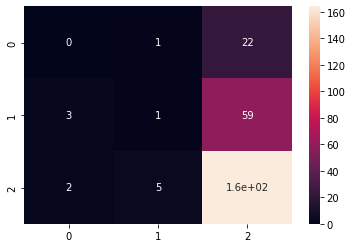

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, testing_prediction)
#print(cm)
sns.heatmap(cm, annot=True)

Without Class Weight

In [ ]:
%time
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Send test data through same feature extractor process
#Need to extract features first from test data, then predict
X_test_feature = VGG_model.predict(test_generator) #extract features using feature extractor(VGG_model.predict)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
training_prediction = model.predict(X_for_training) #actual prediction

In [ ]:
xx = training_prediction.tolist()
print(xx)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
#Now predict using the trained RF model. 
testing_prediction = model.predict(X_test_features) #actual prediction

In [ ]:
xxx = testing_prediction.tolist()
print(xxx)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
train_labels = train_generator.classes

In [ ]:
test_labels = test_generator.classes

In [ ]:
#Print overall training accuracy
from sklearn import metrics
print ("Training Accuracy = ", metrics.accuracy_score(train_labels, training_prediction))

#Print overall testing accuracy
from sklearn import metrics
print ("Test Accuracy = ", metrics.accuracy_score(test_labels, testing_prediction))

Training Accuracy =  0.9858921161825727
Test Accuracy =  0.642023346303502


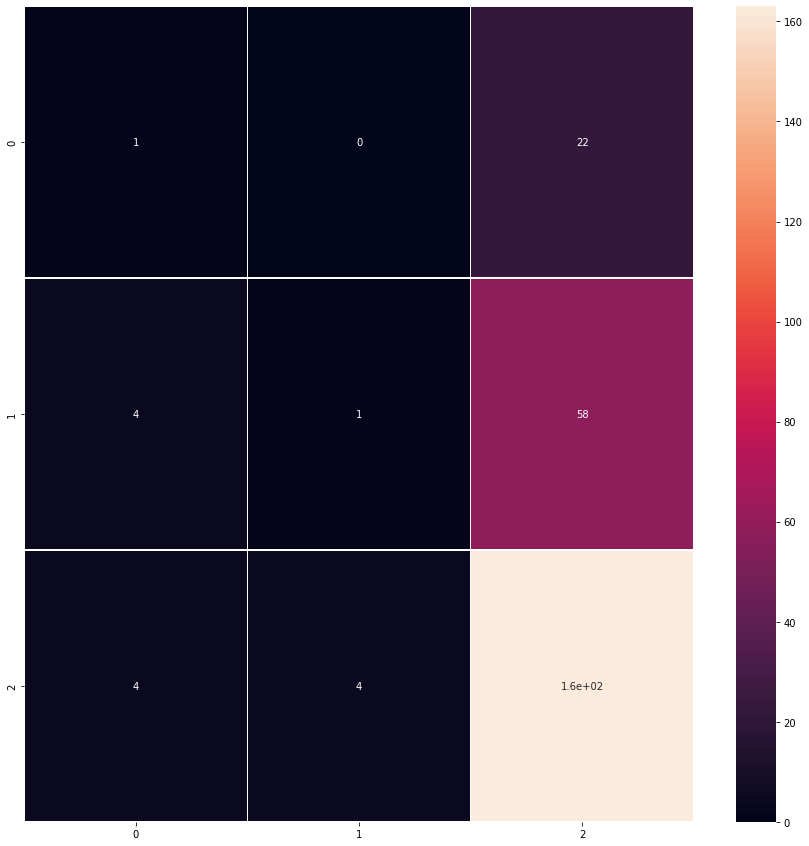

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=(15,15))
cm = confusion_matrix(test_labels, testing_prediction)
#print(cm)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax )

In [ ]:
Precision = TP / TP + FP

0 = 1 / 23
1 = 1 / 63
2 = 160 / 168

Recall  = TP / TP + FN

0 = 1 / 1 + 8
1 = 1 / 5
2 = 160 / 240

100% Faster Preprocessing

In [ ]:
train_data_dir = "/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/train"
test_data_dir = "/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/test"

In [ ]:
path = train_data_dir
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}
    

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}
imageid_path_dict

{}

In [ ]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)

train_datagen = ImageDataGenerator(
      rescale = 1./255)

train_generator =train_datagen.flow_from_directory(
     train_data_dir,
     batch_size= 8,
     seed=42,
     shuffle=True, 
     target_size = (224,224))

test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator =test_datagen.flow_from_directory(
     test_data_dir,
     batch_size= 1,
     seed=42,
     shuffle=False, 
     target_size = (224,224)) 

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_data_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_data_dir, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_data_dir, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
# class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

# class_weight

In [ ]:
y_train = train_generator.classes
y_train

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [ ]:
a = train_generator.labels
a

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [ ]:
y_train_list = y_train.tolist()

In [ ]:
(unique, counts) = np.unique(a, return_counts=True)
print(unique)
print(counts)

[0 1 2]
[1349 1266 3418]


In [ ]:
class_weight = []
for i in y_train_list:
  if i == 0:
    class_weight.append(weight_for_0)
  elif i == 1:
    class_weight.append(weight_for_1)
  else:
    class_weight.append(weight_for_2)

In [ ]:
class_weight_array = np.array(class_weight)

In [ ]:
# import xgboost as xgb
# exgb_classifier = xgboost.XGBClassifier()
# exgb_classifier.fit(X, y, sample_weight=sample_weights_data)
# where the parameter shld be array like, length N, equal to the target length

In [ ]:
SIZE = 224 

In [ ]:
#############################
#Load model without classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

In [ ]:
%time
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(train_generator)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [ ]:
#xgboost takes image in shape of two. So need to reshape (320,8,8,512) 320 Images.
#8x8x512 = 32768
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
#features shape = (320,32768)
X_for_training = features #This is our X input to RF

In [ ]:
%time
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators= 150,
 max_depth=8,
 min_child_weight=2,
 gamma=0.42,
 subsample=0.78,
 colsample_bytree=0.76,
 scale_pos_weight=0.998,
 seed=27)
model.fit(X_for_training, y_train)

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 11.4 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Send test data through same feature extractor process
#Need to extract features first from test data, then predict
X_test_feature = VGG_model.predict(test_generator) #extract features using feature extractor(VGG_model.predict)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
training_prediction = model.predict(X_for_training) #actual prediction
a = training_prediction.tolist()
a

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,


In [ ]:
#Now predict using the trained RF model. 
testing_prediction = model.predict(X_test_features) #actual prediction
b = testing_prediction.tolist()
b

[2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [ ]:
train_labels = train_generator.classes
test_labels = test_generator.classes

In [ ]:
#Print overall training accuracy
from sklearn import metrics
print ("Training Accuracy = ", metrics.accuracy_score(train_labels, training_prediction))

#Print overall testing accuracy
from sklearn import metrics
print ("Test Accuracy = ", metrics.accuracy_score(test_labels, testing_prediction))

Training Accuracy =  0.6235703630034809
Test Accuracy =  0.6645962732919255


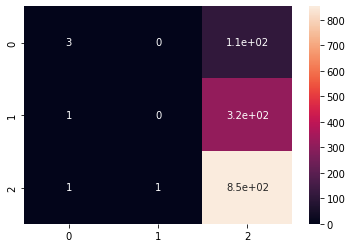

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, testing_prediction)
#print(cm)
sns.heatmap(cm, annot=True)

Using sample_weight/class_Weight


In [ ]:
%time
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train, sample_weight=class_weight_array)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [ ]:
#Send test data through same feature extractor process
#Need to extract features first from test data, then predict
X_test_feature = VGG_model.predict(test_generator) #extract features using feature extractor(VGG_model.predict)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
training_prediction = model.predict(X_for_training) #actual prediction
a = training_prediction.tolist()
a

In [ ]:
#Now predict using the trained RF model. 
testing_prediction = model.predict(X_test_features) #actual prediction

In [ ]:
#Now predict using the trained RF model. 
testing_prediction = model.predict(X_test_features) #actual prediction
b = testing_prediction.tolist()
b

In [ ]:
train_labels = train_generator.classes

In [ ]:
test_labels = test_generator.classes

In [ ]:
#Print overall training accuracy
from sklearn import metrics
print ("Training Accuracy = ", metrics.accuracy_score(train_labels, training_prediction))

#Print overall testing accuracy
from sklearn import metrics
print ("Test Accuracy = ", metrics.accuracy_score(test_labels, testing_prediction))

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, testing_prediction)
#print(cm)
sns.heatmap(cm, annot=True)

20% Slower preprocessing


In [ ]:
%time 

SIZE = 224  #Resize images #original vgg requirements,but for this case (only using convolution layers) then dont have to

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/unique_20_sample_train/*"):
    label = directory_path.split("train/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/unique_20_sample_test/*"):
    test_label = directory_path.split("test/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(test_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
# from keras.utils import to_categorical
# y_train_one_hot = to_categorical(y_train)
# y_test_one_hot = to_categorical(y_test)


In [ ]:
#############################
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Load VGG Model using image net weights, not including the top layers(dense layer) because we are only using it for feature extraction.
Take pre-trained weight and use it as feature extractor (just using the weights and biases, but they are not trainable)
Using this model is to give us an output (which would be our features), no training. 

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

#xgboost takes image in shape of two. So need to reshape (320,8,8,512) 320 Images.
#8x8x512 = 32768
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
#features shape = (320,32768)
X_for_training = features #This is our X input to RF

In [ ]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
train_data_dir = "/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/unique_20_sample_train/"
num_pneumonia = len(os.listdir(os.path.join(train_data_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_data_dir, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_data_dir, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
# class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
# class_weight = [0.2232365145228216,0.2099585062240664,0.566804979253112]

In [ ]:
class_weight = np.array([1]*y_train.shape[0])
class_weight[y_train==1] = weight_for_1
class_weight[y_train==0] = weight_for_0
class_weight[y_train==2] = weight_for_2


In [ ]:
y_train.shape[0]

1205

In [ ]:
print(class_weight)

[0 0 0 ... 0 0 0]


In [ ]:
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train)   #X_for_training is features, y_train is 
# model.fit(X_for_training, y_train, sample_weight=class_weight) #For sklearn no one hot encoding

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Send test data through same feature extractor process
#Need to extract features first from test data, then predict
X_test_feature = VGG_model.predict(x_test) #extract features using feature extractor(VGG_model.predict)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
X_test_features

array([[0.21874559, 0.        , 0.        , ..., 0.        , 0.704333  ,
        0.        ],
       [0.5805739 , 0.        , 0.34016138, ..., 0.        , 0.79343414,
        0.        ],
       [0.52964085, 0.        , 0.        , ..., 0.        , 0.43416393,
        0.        ],
       ...,
       [0.7417048 , 0.        , 0.        , ..., 0.        , 0.568239  ,
        0.        ],
       [0.19245982, 0.        , 0.        , ..., 0.        , 0.43444413,
        0.        ],
       [0.21656182, 0.        , 0.        , ..., 0.        , 0.48737657,
        0.        ]], dtype=float32)

In [ ]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features) #actual prediction

#Inverse le transform to get original label back. 
prediction_transform = le.inverse_transform(prediction)

In [ ]:
prediction_transform = prediction_transform.tolist()

In [ ]:
test_labels = test_labels.tolist()

In [ ]:
#Print overall accuracy
train_labels = train_labels.tolist()
from sklearn import metrics
print ("Training Accuracy = ", metrics.accuracy_score(test_labels, prediction_transform))

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Test Accuracy = ", metrics.accuracy_score(test_labels, prediction_transform))

Accuracy =  0.9299610894941635


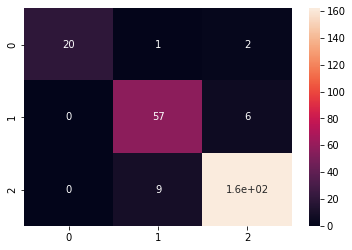

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction_transform)
#print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['PNEUMONIA']
The actual label for this image is:  NORMAL


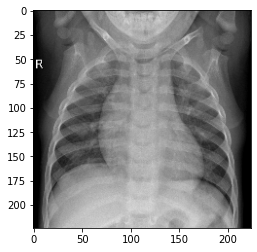

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

100%

In [ ]:
%time 

SIZE = 224  #Resize images #original vgg requirements,but for this case (only using convolution layers) then dont have to

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/train/*"):
    label = directory_path.split("train/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/test/*"):
    test_label = directory_path.split("test/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(test_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
# from keras.utils import to_categorical
# y_train_one_hot = to_categorical(y_train)
# y_test_one_hot = to_categorical(y_test)

In [ ]:
#############################
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

#xgboost takes image in shape of two. So need to reshape (320,8,8,512) 320 Images.
#8x8x512 = 32768
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
#features shape = (320,32768)
X_for_training = features #This is our X input to RF

In [ ]:
# train_data_dir = "/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/train/"
# num_pneumonia = len(os.listdir(os.path.join(train_data_dir, 'PNEUMONIA')))
# num_normal = len(os.listdir(os.path.join(train_data_dir, 'NORMAL')))
# num_covid = len(os.listdir(os.path.join(train_data_dir, 'COVID19')))

# total = num_normal + num_pneumonia + num_covid
# weight_for_0 = num_covid / total
# weight_for_1 = num_normal / total
# weight_for_2 = num_pneumonia / total

# class_weight = np.array([1]*y_train.shape[0])
# class_weight[y_train==1] = weight_for_1
# class_weight[y_train==0] = weight_for_0
# class_weight[y_train==2] = weight_for_2

In [ ]:
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train)
# model.fit(X_for_training, y_train, sample_weight=class_weight) #For sklearn no one hot encoding

In [ ]:
#Send test data through same feature extractor process
#Need to extract features first from test data, then predict
X_test_feature = VGG_model.predict(x_test) #extract features using feature extractor(VGG_model.predict)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features) #actual prediction

#Inverse le transform to get original label back. 
prediction_transform = le.inverse_transform(prediction)
prediction_transform = prediction_transform.tolist()

test_labels = test_labels.tolist()

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_transform))

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction_transform)
#print(cm)
sns.heatmap(cm, annot=True)